# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [6]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 4

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        # x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]           1,152
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           1,152

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1360800713300705 Batch_id=468 Accuracy=82.90: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]



Test set: Average loss: 0.1817, Accuracy: 9631/10000 (96.31%)

EPOCH: 1


Loss=0.08949717879295349 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]



Test set: Average loss: 0.1178, Accuracy: 9698/10000 (96.98%)

EPOCH: 2


Loss=0.06819026172161102 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0677, Accuracy: 9808/10000 (98.08%)

EPOCH: 3


Loss=0.03206330165266991 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]



Test set: Average loss: 0.0771, Accuracy: 9780/10000 (97.80%)

EPOCH: 4


Loss=0.04106604680418968 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0589, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.03907538205385208 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0473, Accuracy: 9864/10000 (98.64%)

EPOCH: 6


Loss=0.14392949640750885 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0440, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.04777325689792633 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0418, Accuracy: 9877/10000 (98.77%)

EPOCH: 8


Loss=0.06220458820462227 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]



Test set: Average loss: 0.0436, Accuracy: 9873/10000 (98.73%)

EPOCH: 9


Loss=0.04181228205561638 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0440, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Loss=0.04725225642323494 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]



Test set: Average loss: 0.0429, Accuracy: 9865/10000 (98.65%)

EPOCH: 11


Loss=0.026945143938064575 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]



Test set: Average loss: 0.0443, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.03876231983304024 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0423, Accuracy: 9878/10000 (98.78%)

EPOCH: 13


Loss=0.03237893804907799 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0425, Accuracy: 9874/10000 (98.74%)

EPOCH: 14


Loss=0.02454174868762493 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]



Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)

EPOCH: 15


Loss=0.036667291074991226 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0417, Accuracy: 9879/10000 (98.79%)

EPOCH: 16


Loss=0.05740618705749512 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]



Test set: Average loss: 0.0426, Accuracy: 9873/10000 (98.73%)

EPOCH: 17


Loss=0.021873531863093376 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]



Test set: Average loss: 0.0431, Accuracy: 9871/10000 (98.71%)

EPOCH: 18


Loss=0.05313733592629433 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0426, Accuracy: 9876/10000 (98.76%)

EPOCH: 19


Loss=0.0506967194378376 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]



Test set: Average loss: 0.0407, Accuracy: 9879/10000 (98.79%)



Text(0.5, 1.0, 'Test Accuracy')

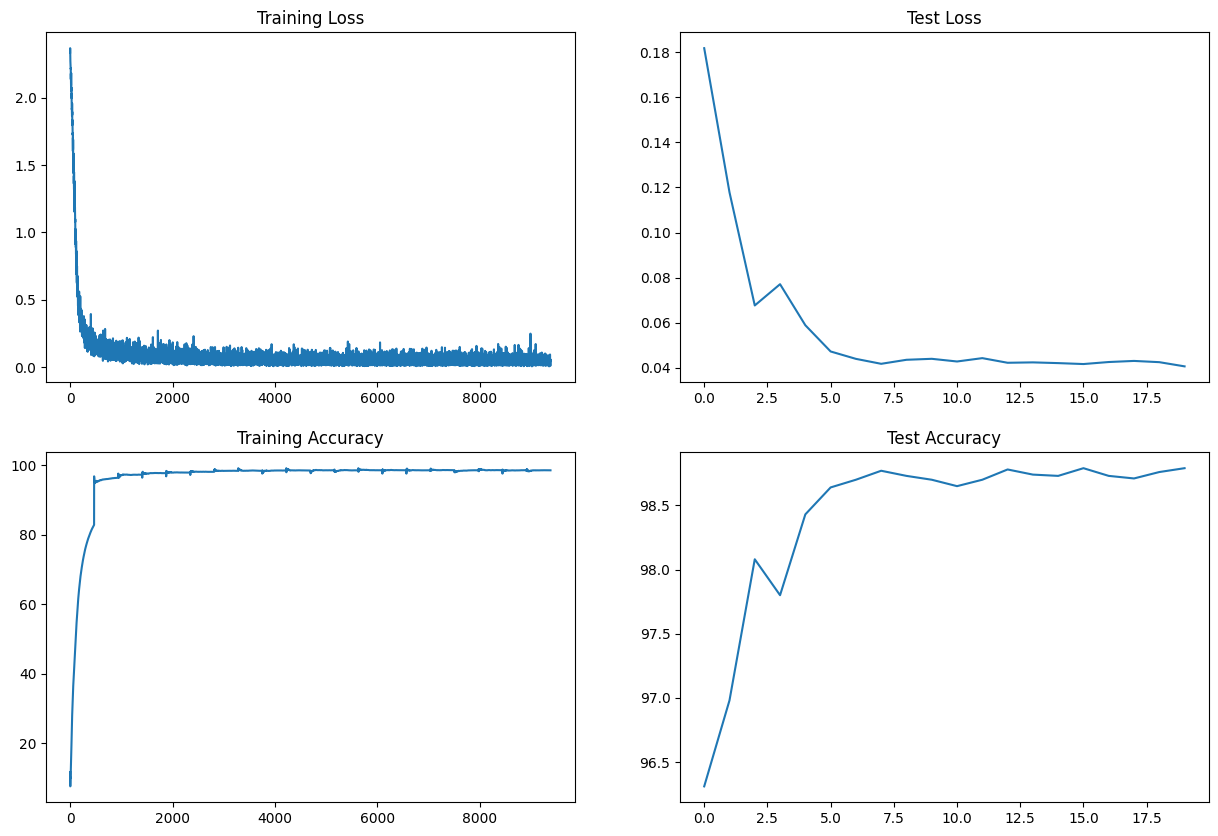

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")